# Jugando la Copa América con Python

*Esta notebook fue creada originalmente como un blog post por [Raúl E. López Briega](https://relopezbriega.com.ar/) en [Matemáticas, Analisis de datos y Python](https://relopezbriega.github.io). El contenido esta bajo la licencia BSD.*

<img alt="Copa América" title="Copa América" src="https://relopezbriega.github.io/images/copa_america.png" width="60%" height="60%">

> "Tengo dos problemas para jugar al fútbol. Uno es la pierna izquierda. El otro es la pierna derecha."

**[Roberto Fontarrosa](https://es.wikipedia.org/wiki/Roberto_Fontanarrosa)**

## Introducción

Futbol...Fubol...o Fuchibol...sin dudas uno de los deportes más hermosos del mundo y una pasión de multitudes! Cada vez que la pelota rueda sobre el verde cesped, los corazones se aceleran, el aire se entrecorta y la tensión se acumula en todos los estadios...

Quién no ha soñado alguna vez con convertirse en un astro del balonpié...para ver luego como ese sueño se hace añicos y terminar rememorando los viejos tiempos en que las rodillas no dolian, o la panza no hacía de contrapeso y podíamos deslizarnos por el campo eludiendo rivales con la pelota entre los pies!...O para aquellos que no fuimos tan agraciados con un talento natural y éramos más rústicos...el éxito residía en no dejar pasar al rival a como dé lugar...aplicando tal vez un par de patadas si la situación lo requería.

Siempre que comienza una nueva competición futbolística, y sobre todo cuando juega la selección nacional, que representa los colores de todo un país...la pasión y el entusiasmo se renuevan para volver a alentar al equipo en la búsqueda de la gloria!

Como sabemos, ya falta muy poco para que comience la [Copa América](https://copaamerica.com/), torneo en que las selecciones de sudamérica se mediran para determinar quien es el mejor del continente.
En Argentina, donde a la mayoría nos encanta discutir sobre futbol y hacer predicciones, cada vez que empieza un torneo como este, solemos jugar al [prode](https://es.wikipedia.org/wiki/Pron%C3%B3sticos_deportivos)...juego que consiste en predecir los resultados que se van a dar en la competición en cuestión.

Y que mejor que aplicar un poco de estadística y ayudarnos de [Python](https://www.python.org/) para intentar predecir los resultados y ver que suerte acompañará a la gloriosa selección albiceleste!


## Predicción de resultados de la Copa América

Para intentar predecir los resultados de la [Copa América](https://copaamerica.com/) voy a utilizar un modelo simple de [Regresión Logística](https://es.wikipedia.org/wiki/Regresi%C3%B3n_log%C3%ADstica) que adapté de [Kaggle](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner); en dónde las principales variales para predecir los resultados serán el [ranking FIFA](https://es.fifa.com/fifa-world-ranking/ranking-table/men/) de cada equipo, el talento de sus jugadores y el historial de enfrentamientos.

### Los datos

Los datos que utilicé los armé en base a otros datasets que obtuve de [Kaggle](https://www.kaggle.com/datasets). Se los pueden descargar de los siguientes links:

* **[equipos](https://github.com/relopezbriega/relopezbriega.github.io/blob/master/downloads/CopaAmerica/selecciones.csv):** Este dataset contiene los datos de los jugadores convocados en cada selección.

* **[partidos](https://github.com/relopezbriega/relopezbriega.github.io/blob/master/downloads/CopaAmerica/partidos.csv):** Este dataset contine el historial de partidos en que se enfrentaron las selecciones que participan de la copa.

* **[copa](https://github.com/relopezbriega/relopezbriega.github.io/blob/master/downloads/CopaAmerica/CopaAmerica.csv):** Este dataset contine la composición de los grupos de la [Copa América](https://copaamerica.com/).

Comencemos con el modelo...

In [1]:
# <!-- collapse=True -->
# Importando las librerías que vamos a utilizar
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

#utilizar SQL para filtrar pandas df
query = lambda q: sqldf(q, globals())

# graficos incrustados
%matplotlib inline

In [2]:
# importando los datos
# jugadores de las selecciones 
equipos = pd.read_csv('data/selecciones.csv')
# completando el overall de jugadores faltantes
equipos['Overall'] = equipos['Overall'].fillna(65)

# Historial de partidos entre las selecciones
partidos = pd.read_csv('data/partidos.csv')

# Grupos Copa América Brasil 2019
copa = pd.read_csv('data/CopaAmerica.csv')

Hay quienes dicen que los mundiales de futbol son un gran [metegol](https://es.wikipedia.org/wiki/F%C3%BAtbol_de_mesa) con el que juegan los Dioses...aplicando esa analogía yo tomé las estadísticas de los jugadores del videojuego FIFA19 para determinar el talento general que le corresponde a cada selección y ese número se ve reflejado en la columna `Overal` del dataset de [equipos](https://github.com/relopezbriega/relopezbriega.github.io/blob/master/downloads/CopaAmerica/selecciones.csv)...agreguemos también ese dato a los dataset de [partidos](https://github.com/relopezbriega/relopezbriega.github.io/blob/master/downloads/CopaAmerica/partidos.csv) y de [copa](https://github.com/relopezbriega/relopezbriega.github.io/blob/master/downloads/CopaAmerica/CopaAmerica.csv) para facilitar el acceso a ese dato.

In [3]:
# Agregando el pontencial del equipo al dataset de partidos
potencial = equipos.groupby('selección').mean()['Overall']
partidos = partidos.merge(potencial, 
                        left_on=['local'], 
                        right_on=['selección'])
partidos = partidos.merge(potencial, 
                        left_on=['visitante'], 
                        right_on=['selección'], 
                        suffixes=('_local', '_visitante'))

# Agregar diferencia de potencial entre los equipos
partidos['dif_potencial'] = partidos['Overall_local'] - partidos['Overall_visitante']

# Agregando el pontencial del equipo al dataset de copa
copa = copa.merge(potencial, 
                        left_on=['equipo'], 
                        right_on=['selección'])
copa = copa.set_index(['equipo'])

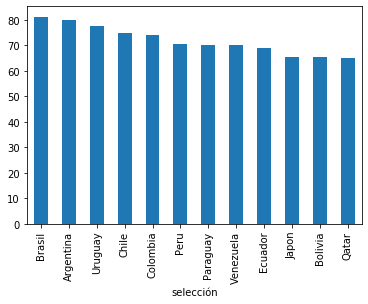

In [4]:
# Graficando el potencial de cada seleccion
# de acuerdo a la jerarquía de sus jugadores
plot = potencial.sort_values( ascending=False).plot(kind='bar')

Como vemos en este gráfico...los grandes candidatos de acuerdo a la calidad de sus jugadores son Brasil, Argentina y Uruguay..ahora armemos el modelo

## Modelo

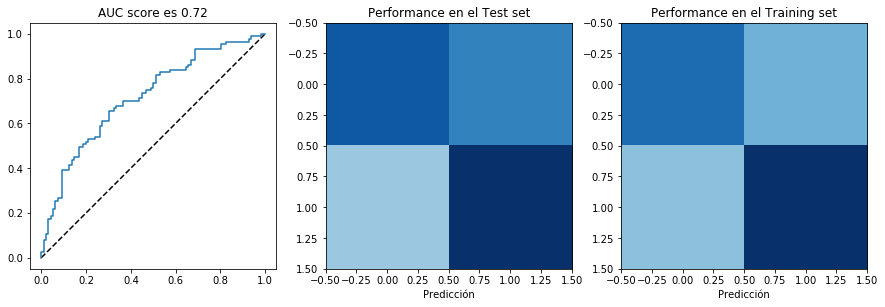

In [5]:
# Armado del modelo de regresión lineal para predecir los resultados
# los predictores a utilizar seran la diferencia del ranking fifa y el potencial
# de los jugadores de las selecciones

X, y = partidos.loc[:,['ranking_local', 'dif_ranking', 'dif_potencial']], partidos['gana_local']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(solver='lbfgs', C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# Graficos 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score es {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicción')
ax.set_title('Performance en el Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicción')
ax.set_title('Performance en el Training set')
plot = plt.show()

El modelo tiene una precisión del 72% no es un gran resultado...pero es decente teniendo en cuenta que los resultados del futbol no se caracterizan por ser fáciles de predecir...si hay algo hermoso que tiene este deporte...es que siempre te da sorpresas!

continuemos ahora con la simulación de la fase de grupos

## Simulación de fase de grupos

In [6]:
# Simulando los partidos de la fase de grupos
from itertools import combinations

# margen de error para definir empate en casos parejos
margin = 0.05

copa['puntos'] = 0
copa['total_prob'] = 0

for grupo in sorted(set(copa['grupo'])):
    print('___Grupo {}:___'.format(grupo))
    for local, visitante in combinations(copa.query('grupo == "{}"'.format(grupo)).index, 2):
        print("{} vs. {}: ".format(local, visitante), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=X_test.columns)
        row['ranking_local'] = copa.loc[local, 'ranking FIFA']
        opp_rank = copa.loc[visitante, 'ranking FIFA']
        local_pot = copa.loc[local, 'Overall']
        opp_pot = copa.loc[visitante, 'Overall']
        row['dif_ranking'] = row['ranking_local'] - opp_rank 
        row['dif_potencial'] = local_pot - opp_pot  
        local_win_prob = model.predict_proba(row)[:,1][0]
        copa.loc[local, 'total_prob'] += local_win_prob
        copa.loc[visitante, 'total_prob'] += 1-local_win_prob
        
        # Asignando los puntos en a los equipos en el grupo
        points = 0
        if local_win_prob <= 0.5 - margin:
            print("{} gana con prob de {:.3f}".format(visitante, 1-local_win_prob))
            copa.loc[visitante, 'puntos'] += 3
        if local_win_prob > 0.5 - margin:
            points = 1
        if local_win_prob >= 0.5 + margin:
            points = 3
            copa.loc[local, 'puntos'] += 3
            print("{} gana con prob de {:.3f}".format(local, local_win_prob))
        if points == 1:
            print("empatan")
            copa.loc[local, 'puntos'] += 1
            copa.loc[visitante, 'puntos'] += 1

___Grupo A:___
Brasil vs. Bolivia: Brasil gana con prob de 0.785
Brasil vs. Venezuela: Brasil gana con prob de 0.622
Brasil vs. Peru: Brasil gana con prob de 0.591
Bolivia vs. Venezuela: Venezuela gana con prob de 0.639
Bolivia vs. Peru: Peru gana con prob de 0.667
Venezuela vs. Peru: empatan
___Grupo B:___
Argentina vs. Colombia: empatan
Argentina vs. Paraguay: Argentina gana con prob de 0.637
Argentina vs. Qatar: Argentina gana con prob de 0.765
Colombia vs. Paraguay: Colombia gana con prob de 0.573
Colombia vs. Qatar: Colombia gana con prob de 0.687
Paraguay vs. Qatar: Paraguay gana con prob de 0.655
___Grupo C:___
Uruguay vs. Ecuador: Uruguay gana con prob de 0.681
Uruguay vs. Japon: Uruguay gana con prob de 0.623
Uruguay vs. Chile: empatan
Ecuador vs. Japon: empatan
Ecuador vs. Chile: Chile gana con prob de 0.675
Japon vs. Chile: Chile gana con prob de 0.586


In [7]:
# ver posiciones de grupos
copa = copa.sort_values(by=['grupo', 'puntos', 'total_prob'], ascending=[True, False, False]).reset_index()

In [8]:
# Seleccionar quienes pasan de ronda
next_round = copa.groupby('grupo').nth([0, 1, 2]).reset_index() # primeros 3
next_round[['grupo','equipo', 'puntos']]

,grupo,equipo,puntos
0,A,Brasil,9
1,A,Peru,4
2,A,Venezuela,4
3,B,Argentina,7
4,B,Colombia,7
5,B,Paraguay,3
6,C,Uruguay,7
7,C,Chile,7
8,C,Japon,1


Ahora que ya tenemos las predicciones de quienes superarán la primera fase y continuarán compitiendo para alzar la copa y la gloria...simulemos la fase final y veamos quien se convierte en campeón!

## Simulando fase final

In [9]:
# Armo los cruces...el peor 3ro queda afuera de cuartos
cruces = [0,5,1,4,3,7,6,2]

next_round = next_round.loc[cruces]
next_round = next_round.set_index('equipo')

In [10]:
# Simulo rondas finales
finales = ['cuartos de final', 'semifinal', 'final']

copa = copa.set_index(['equipo'])

for f in finales:
    print("___Ronda {}___".format(f))
    iterations = int(len(next_round) / 2)
    winners = []

    for i in range(iterations):
        local = next_round.index[i*2]
        visitante = next_round.index[i*2+1]
        print("{} vs. {}: ".format(local,
                                   visitante), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=X_test.columns)
        row['ranking_local'] = copa.loc[local, 'ranking FIFA']
        opp_rank = copa.loc[visitante, 'ranking FIFA']
        local_pot = copa.loc[local, 'Overall']
        opp_pot = copa.loc[visitante, 'Overall']
        row['dif_ranking'] = row['ranking_local'] - opp_rank 
        row['dif_potencial'] = local_pot - opp_pot  
        local_win_prob = model.predict_proba(row)[:,1][0]
        copa.loc[local, 'total_prob'] += local_win_prob
        copa.loc[visitante, 'total_prob'] += 1-local_win_prob

        local_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} gana con prob de {1:.3f}".format(visitante, 1-local_win_prob))
            winners.append(visitante)
        else:
            print("{0} gana con prob de {1:.3f}".format(local, local_win_prob))
            winners.append(local)
                
    next_round = next_round.loc[winners]
    print("\n")

___Ronda cuartos de final___
Brasil vs. Paraguay: Brasil gana con prob de 0.642
Peru vs. Colombia: Colombia gana con prob de 0.540
Argentina vs. Chile: Argentina gana con prob de 0.532
Uruguay vs. Venezuela: Uruguay gana con prob de 0.591


___Ronda semifinal___
Brasil vs. Colombia: Brasil gana con prob de 0.541
Argentina vs. Uruguay: Uruguay gana con prob de 0.503


___Ronda final___
Brasil vs. Uruguay: Brasil gana con prob de 0.512




Si bien el modelo es simple...y seguramente se puede armar un poco más sofisticado...los resultados se ven bastante lógicos de acuerdo a la tradición y el presente futbolístico de cada selección.

Como vemos, de acuerdo a este modelo...la albiceleste pierde en semifinales en forma reñida contra los charrúas...el campeón termina siendo Brasil...esperemos que los resultados esten errados y en esta ocasión Messi pueda lograr el tan ansiado título con la selección!

Saludos!

*Este post fue escrito por [Raúl e. López Briega](https://relopezbriega.github.io/) utilizando [Jupyter notebook](https://jupyter.org/). Pueden descargar este [notebook](https://github.com/relopezbriega/relopezbriega.github.io/blob/master/downloads/CopaAmerica.ipynb) o ver su version estática en [nbviewer](https://nbviewer.ipython.org/github/relopezbriega/relopezbriega.github.io/blob/master/downloads/CopaAmerica.ipynb).*